In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Lab | Natural Language Processing
### SMS: SPAM or HAM

### Let's prepare the environment

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

- Read Data for the Fraudulent Email Kaggle Challenge
- Reduce the training set to speead up development.

In [5]:
from google.colab import files

# Abre un cuadro de diálogo para subir archivos desde tu PC
uploaded = files.upload()


Saving kg_train.csv to kg_train.csv


In [6]:
from google.colab import files

# Abre un cuadro de diálogo para subir archivos desde tu PC
uploaded = files.upload()


Saving kg_test.csv to kg_test.csv


In [18]:
## Read Data for the Fraudulent Email Kaggle Challenge
data = pd.read_csv("/content/kg_train.csv",encoding='latin-1')

# Reduce the training set to speed up development.
# Modify for final system
data = data.head(1000)
print(data.shape)
data.fillna("",inplace=True)

(1000, 2)


### Let's divide the training and test set into two partitions

In [19]:
# Your code
from sklearn.model_selection import train_test_split

# Assuming the target column is called 'label'
# Change 'label' to your actual target column name if it’s different
X = data.drop('label', axis=1)  # Features (independent variables)
y = data['label']               # Target (dependent variable)

# Split the dataset: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Display sizes of each partition
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (800, 1)
Test set size: (200, 1)


## Data Preprocessing

In [20]:
import string
from nltk.corpus import stopwords
print(string.punctuation)
print(stopwords.words("english")[100:110])
from nltk.stem.snowball import SnowballStemmer
snowball = SnowballStemmer('english')

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
['needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on']


## Now, we have to clean the html code removing words

- First we remove inline JavaScript/CSS
- Then we remove html comments. This has to be done before removing regular tags since comments can contain '>' characters
- Next we can remove the remaining tags

In [21]:
# Your code

import re

def clean_html(text):
    """
    Cleans HTML text by removing:
    1. Inline JavaScript and CSS
    2. HTML comments
    3. All remaining HTML tags
    """
    # Remove inline JavaScript/CSS code
    text = re.sub(r'<(script|style).*?>.*?</\1>', '', text, flags=re.DOTALL)

    # Remove HTML comments (must come before removing tags)
    text = re.sub(r'<!--.*?-->', '', text, flags=re.DOTALL)

    # Remove all remaining HTML tags
    text = re.sub(r'<[^>]+>', '', text)

    # Remove extra whitespace and line breaks
    text = re.sub(r'\s+', ' ', text).strip()

    return text


- Remove all the special characters
    
- Remove numbers
    
- Remove all single characters

- Remove single characters from the start

- Substitute multiple spaces with single space

- Remove prefixed 'b'

- Convert to Lowercase

In [22]:
# Your code

import re

def normalize_text(text):
    """
    Performs general text normalization:
    - Removes special characters and punctuation
    - Removes numbers
    - Removes single characters
    - Removes single characters from start
    - Replaces multiple spaces with a single space
    - Removes prefixed 'b' (from byte strings)
    - Converts text to lowercase
    """
    # 1️⃣ Remove special characters and punctuation
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    # 2️⃣ Remove numbers
    text = re.sub(r'\d+', ' ', text)

    # 3️⃣ Remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

    # 4️⃣ Remove single characters from start
    text = re.sub(r'^[a-zA-Z]\s+', '', text)

    # 5️⃣ Substitute multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)

    # 6️⃣ Remove prefixed 'b' (from byte strings like b'text')
    text = re.sub(r'^b\s+', '', text)

    # 7️⃣ Convert to lowercase
    text = text.lower()

    return text.strip()


## Now let's work on removing stopwords
Remove the stopwords.

In [23]:
# Your code

# Function to remove stopwords
def remove_stopwords(text):
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return " ".join(filtered_tokens)



## Tame Your Text with Lemmatization
Break sentences into words, then use lemmatization to reduce them to their base form (e.g., "running" becomes "run"). See how this creates cleaner data for analysis!

In [24]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download required data (run once)
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [25]:
# Your code

def lemmatize_text(text):
    """
    Breaks text into words and reduces each word to its base form.
    Example: 'running dogs' → 'run dog'
    """
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(lemmatized_words)


## Bag Of Words
Let's get the 10 top words in ham and spam messages (**EXPLORATORY DATA ANALYSIS**)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


📩 Top 10 words in HAM messages:

state      136
pm         127
call       115
would      107
work       107
presid     102
time        98
mr          86
obama       86
percent     81
dtype: int64

🚨 Top 10 words in SPAM messages:

money       981
account     942
bank        888
fund        787
us          734
transfer    573
transact    555
foreign     530
busi        520
countri     509
dtype: int64


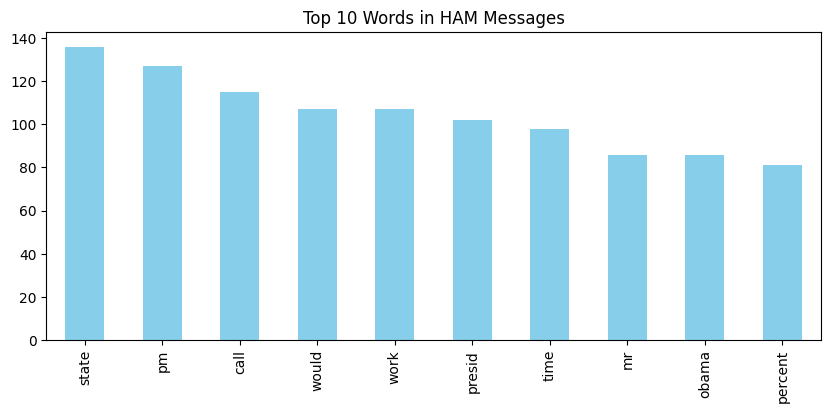

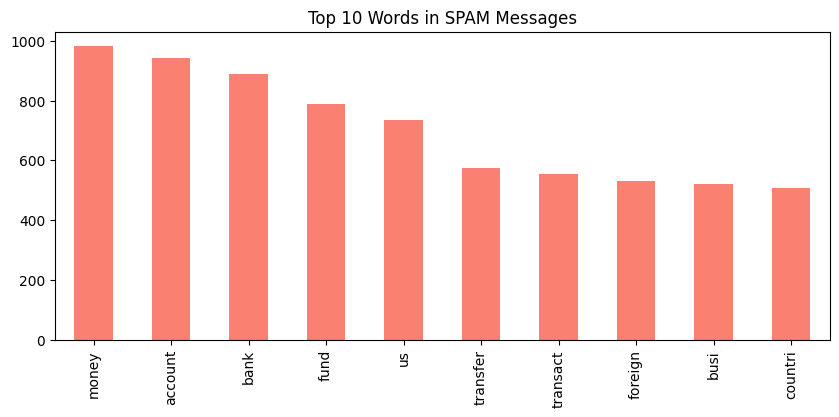

In [29]:
# ===============================================================
# 🧮 BAG OF WORDS (BoW) ANALYSIS
# ===============================================================
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

# Download necessary NLTK data (stopwords, punkt, punkt_tab)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab') # Added punkt_tab download

# Function to clean HTML
def clean_html(text):
    text = re.sub(r'<(script|style).*?>.*?</\1>', '', text, flags=re.DOTALL)
    text = re.sub(r'<!--.*?-->', '', text, flags=re.DOTALL)
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Function to normalize text (from K9mV7HHbZK8L)
def normalize_text(text):
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'^[a-zA-Z]\s+', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'^b\s+', '', text)
    text = text.lower()
    return text.strip()

# Function to remove stopwords
def remove_stopwords(text):
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return " ".join(filtered_tokens)

# Function to stem text using SnowballStemmer (from 3dc-oCHlk6jT)
def stem_text(text):
    snowball = SnowballStemmer('english')
    tokens = word_tokenize(text)
    stemmed_words = [snowball.stem(word) for word in tokens]
    return " ".join(stemmed_words)


# Apply cleaning and preprocessing steps
# Assuming your original text column is named 'text'
data['clean_text'] = data['text'].apply(clean_html)
data['clean_text'] = data['clean_text'].apply(normalize_text)
data['clean_text'] = data['clean_text'].apply(remove_stopwords)
data['clean_text'] = data['clean_text'].apply(stem_text) # Added stemming


# 1️⃣ Create Bag of Words representation
vectorizer = CountVectorizer(max_features=5000)  # limit vocabulary for performance
# Check if 'clean_text' column exists before fitting
if 'clean_text' in data.columns:
    X_bow = vectorizer.fit_transform(data['clean_text'])

    # 2️⃣ Convert to DataFrame
    bow_df = pd.DataFrame(X_bow.toarray(), columns=vectorizer.get_feature_names_out())

    # 3️⃣ Separate HAM and SPAM messages
    # ⚠️ Adjust depending on your label values
    # Ensure 'label' column exists
    if 'label' in data.columns:
        # Assuming 0 is HAM and 1 is SPAM based on previous code logic
        ham_df = bow_df[data['label'] == 0]   # Non-spam
        spam_df = bow_df[data['label'] == 1]  # Spam

        # 4️⃣ Calculate total word counts
        ham_words = ham_df.sum().sort_values(ascending=False).head(10)
        spam_words = spam_df.sum().sort_values(ascending=False).head(10)

        # 5️⃣ Display results
        print("📩 Top 10 words in HAM messages:\n")
        print(ham_words)

        print("\n🚨 Top 10 words in SPAM messages:\n")
        print(spam_words)

        # 6️⃣ Optional: Visualize the top words
        plt.figure(figsize=(10,4))
        ham_words.plot(kind='bar', color='skyblue', title='Top 10 Words in HAM Messages')
        plt.show()

        plt.figure(figsize=(10,4))
        spam_words.plot(kind='bar', color='salmon', title='Top 10 Words in SPAM Messages')
        plt.show()
    else:
        print("Error: 'label' column not found in the DataFrame.")
else:
    print("Error: 'clean_text' column not found after preprocessing.")

## Extra features

In [31]:
# We add to the original dataframe two additional indicators (money symbols and suspicious words).

# Define cleaning functions again (or ensure they are defined in a previous executed cell)
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

# Assuming necessary NLTK data (stopwords, punkt) has been downloaded in a previous cell

# Function to clean HTML
def clean_html(text):
    text = re.sub(r'<(script|style).*?>.*?</\1>', '', text, flags=re.DOTALL)
    text = re.sub(r'<!--.*?-->', '', text, flags=re.DOTALL)
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Function to normalize text (from K9mV7HHbZK8L)
def normalize_text(text):
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'^[a-zA-Z]\s+', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'^b\s+', '', text)
    text = text.lower()
    return text.strip()

# Function to remove stopwords
def remove_stopwords(text):
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return " ".join(filtered_tokens)

# Function to stem text using SnowballStemmer (from 3dc-oCHlk6jT)
def stem_text(text):
    snowball = SnowballStemmer('english')
    tokens = word_tokenize(text)
    stemmed_words = [snowball.stem(word) for word in tokens]
    return " ".join(stemmed_words)

# Apply cleaning and preprocessing steps to X_train and X_test
X_train['preprocessed_text'] = X_train['text'].apply(clean_html).apply(normalize_text).apply(remove_stopwords).apply(stem_text)
X_test['preprocessed_text'] = X_test['text'].apply(clean_html).apply(normalize_text).apply(remove_stopwords).apply(stem_text)


money_simbol_list = "|".join(["euro","dollar","pound","€",r"\$"])
suspicious_words = "|".join(["free","cheap","sex","money","account","bank","fund","transfer","transaction","win","deposit","password"])

X_train['money_mark'] = X_train['preprocessed_text'].str.contains(money_simbol_list)*1
X_train['suspicious_words'] = X_train['preprocessed_text'].str.contains(suspicious_words)*1
X_train['text_len'] = X_train['preprocessed_text'].apply(lambda x: len(x))

X_test['money_mark'] = X_test['preprocessed_text'].str.contains(money_simbol_list)*1
X_test['suspicious_words'] = X_test['preprocessed_text'].str.contains(suspicious_words)*1
X_test['text_len'] = X_test['preprocessed_text'].apply(lambda x: len(x))

print("X_train with extra features:")
display(X_train.head())
print("\nX_test with extra features:")
display(X_test.head())

X_train with extra features:


,text,preprocessed_text,money_mark,suspicious_words,text_len
442,Dear=2C Good day hope fine=2Cdear am writting ...,dear good day hope fine cdear writ mail due re...,1,1,905
962,FROM MR HENRY KABORETHE CHIEF AUDITOR INCHARGE...,mr henri kaboreth chief auditor inchargeforeig...,0,1,1710
971,Will do.,,0,0,0
190,FROM THE DESK OF DR.ADAMU ISMALERAUDITING AND...,desk dr adamu ismaleraudit account manag bank ...,1,1,347
551,"Dear Friend, My name is LOI C.ESTRADA,The wife...",dear friend name loi estrada wife mr josephest...,1,1,1304



X_test with extra features:


,text,preprocessed_text,money_mark,suspicious_words,text_len
222,STRICTLY PERSONALPermit me to introduce myself...,strict personalpermit introduc mr joyc zuma ba...,0,1,515
824,Dear Nancy--I very much want to meet and we've...,dear nanci much want meet tri pin schedul enou...,0,0,200
505,REQUEST FOR BUSINESS PARTNERSHIPI am PATRICK A...,request busi partnershipi patrick atik directo...,1,1,1792
165,Soneri Bank LimitedSilver Jubilee Center=2CBri...,soneri bank limitedsilv jubile center cbritto ...,1,1,1650
832,"Dear Partner,I am a Fund Manager with Fidelity...",dear partner fund manag fidel invest uk handl ...,0,1,588


## How would work the Bag of Words with Count Vectorizer concept?

In [32]:
# Your code
from sklearn.feature_extraction.text import CountVectorizer

texts = ["Free money now", "Win money win prizes", "Free prizes now"]

# 1️⃣ Create the vectorizer
vectorizer = CountVectorizer()

# 2️⃣ Fit and transform your text data
X_bow = vectorizer.fit_transform(texts)

# 3️⃣ See the vocabulary
print(vectorizer.get_feature_names_out())

# 4️⃣ Convert to array
print(X_bow.toarray())


['free' 'money' 'now' 'prizes' 'win']
[[1 1 1 0 0]
 [0 1 0 1 2]
 [1 0 1 1 0]]


## TF-IDF

- Load the vectorizer

- Vectorize all dataset

- print the shape of the vetorized dataset

In [33]:
# Your code
# ===============================================================
# 🧮 TF-IDF Vectorization
# ===============================================================
from sklearn.feature_extraction.text import TfidfVectorizer

# 1️⃣ Create the vectorizer
# You can limit max_features to speed up (e.g., 5000)
vectorizer = TfidfVectorizer(max_features=5000)

# 2️⃣ Fit the vectorizer to the entire dataset and transform the text
X_tfidf = vectorizer.fit_transform(data['clean_text'])

# 3️⃣ Print the shape of the resulting matrix
print("TF-IDF matrix shape:", X_tfidf.shape)


TF-IDF matrix shape: (1000, 5000)


## And the Train a Classifier?

Training set shape: (800, 5000)
Test set shape: (200, 5000)

✅ Accuracy: 0.975

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       112
           1       1.00      0.94      0.97        88

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200



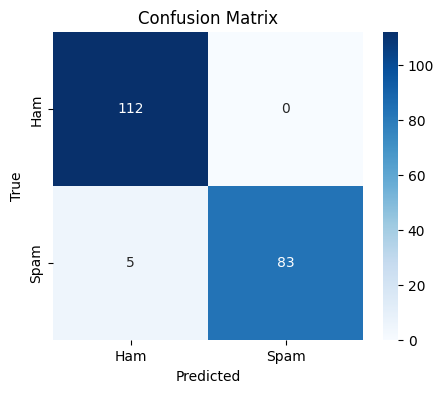

In [34]:
# Your code

# ===============================================================
# 🧠 Train a Classifier using TF-IDF features
# ===============================================================
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Split the TF-IDF data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf,
    data['label'],       # Target column (0 = ham, 1 = spam)
    test_size=0.2,
    random_state=42,
    stratify=data['label']
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

# 2️⃣ Initialize and train the Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 3️⃣ Make predictions
y_pred = model.predict(X_test)

# 4️⃣ Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("\n✅ Accuracy:", round(accuracy, 4))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))

# 5️⃣ Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham','Spam'], yticklabels=['Ham','Spam'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


### Extra Task - Implement a SPAM/HAM classifier

https://www.kaggle.com/t/b384e34013d54d238490103bc3c360ce

The classifier can not be changed!!! It must be the MultinimialNB with default parameters!

Your task is to **find the most relevant features**.

For example, you can test the following options and check which of them performs better:
- Using "Bag of Words" only
- Using "TF-IDF" only
- Bag of Words + extra flags (money_mark, suspicious_words, text_len)
- TF-IDF + extra flags


You can work with teams of two persons (recommended).

In [ ]:
# Your code